<a href="https://colab.research.google.com/github/megangrannan/Portfolio/blob/master/Coach_Viva_Database_and_Dashboard_for_KPIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coach Viva Database and Dashboard for KPIs

# Project Architecture

The structure of this project includes:
- Pulling raw metrics on monthly basis from multiple sources (YouTube, ConvertKit, Google Analytics, etc)
- Cleaning and transforming raw metrics into KPI metrics (CAS - Central Analytics System)
- Writing KPI metrics to a database (Firestore)
- Dashboard webpage pulls data from database

In later phases, this analytics system will connect with Amplitude data and future website/app data.

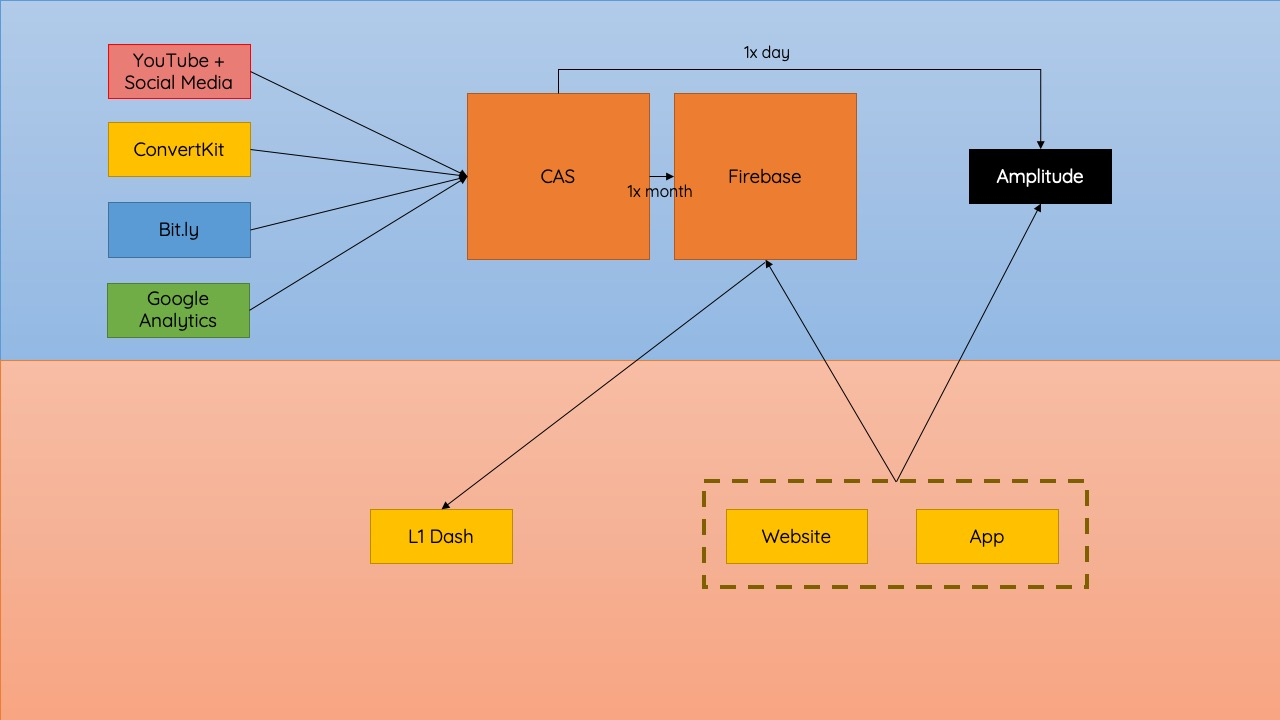

# Dashboard

**GOAL:** Help Coach Viva identify and solve bottlenecks preventing their sales engine from becoming a predictable revenue machine.

This was accomplished by capturing Coach Viva's monthly KPIs for their sales engine in a one-page view to quickly and confidently identify bottlenecks. 

The image below shows the layout of the dashboard and the KPI metrics tracked. 

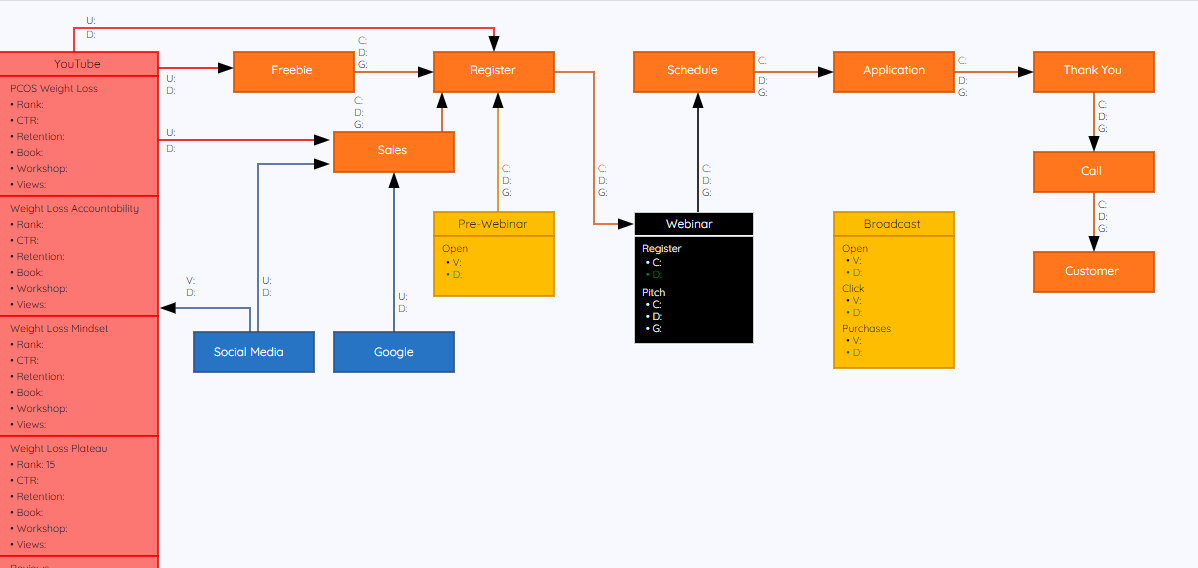

# Code Excerpts

Below are several code excerpts from my work on this project. 

### Automating date setting

**GOAL:** Get KPIs for this month and compare them to the prior month to easily identify bottlenecks.

This code block automatically sets all the dates that will be used within our code, including: 
* Queries
* API calls
* Retreiving data from the database
* Writing new data to the database

Here's how it works:
1. Find today's date
2. Use datetime math to calculate the start and end dates

Expanding on that last point, let's run through an example:
1. We run the code on March 3rd
2. It automatically collects February's data from all our sources
3. It gets January's data from the database in order to calculate month over month differences in performance
4. Writes all of February's data to the database



In [ ]:
# Set dates to run code for

today = datetime.today()  # Get today's date
first_of_current_month = today.replace(day=1)  # Get 1st of current month
# today = datetime.strptime('2020-01-01', "%Y-%m-%d")  # Option to manually change date for testing purposes
end_of_last_month = first_of_current_month - timedelta(days=1)  # Calculate End date
start_of_last_month = first_of_current_month - dateutil.relativedelta.relativedelta(months=1)  # Calculate Start date
prev_mo = first_of_current_month - dateutil.relativedelta.relativedelta(months=2)  # Previous month to query for in Firestore

# Convert dates to string form - for queries, API calls, Firestore read/write data
start_date = start_of_last_month.strftime("%Y-%m-%d")
end_date = end_of_last_month.strftime("%Y-%m-%d")
month = end_of_last_month.strftime('%Y.%m')
previous_month = prev_mo.strftime('%Y.%m')

# Print dates to console
print(f'Start date: {start_date}')
print(f'End date: {end_date}')
print(f'Month: {month}')
print(f'Previous month: {previous_month}')

### Function to make ConvertKit API calls

**GOAL:** Spot which email sequences are underperforming.

This function makes API calls to various endpoints for ConvertKit (an email service provider). 

It takes as input the specific endpoint we want to query, 
along with the id of the tag or form we want information on. 

The function then makes the API request and:
1. Gets data on both active and cancelled subscribers
2. Filters the data to match the date range set earlier in the code (start_date and end_date)
3. Returns a count of the new subscribers within this timeframe



In [ ]:
# Function to make ConvertKit API requests and extract relevant data - returns new subscriber count

def ck_api_call(base_url, id):

  # We need to request data on both active and cancelled subscribers
  subscriber_states = ['&subscriber_state=active', '&subscriber_state=cancelled']
  tag_sub_count = 0
  
  for subscriber_state in subscriber_states:
      # We will make the request to the url built from the specific endpoint, id, and subscriber state we want, plus our api key
      url = base_url + str(id) + '/subscriptions?' + api_secret + subscriber_state
      response = requests.get(url)
      response_j = response.json() 
  
      # Count total pages in response
      total_pages = response_j['total_pages']
   
      # Collect tag subscriber information for first page in response - count new subscribers per month
      for subscription in response_j['subscriptions']:
        if subscription['created_at'][:10] >= start_date and subscription['created_at'][:10] <= end_date:
          tag_sub_count += 1

      # Make requests for any additional pages, and count results 
      for i in range(2, total_pages+1):
        new_url = url + '&page=' + str(i)
        response = requests.get(new_url)
        response_j = response.json()

        for subscription in response_j['subscriptions']:
          if subscription['created_at'][:10] >= start_date and subscription['created_at'][:10] <= end_date:
            tag_sub_count += 1

  # Return count of new subscribers to the id/tag 
  return tag_sub_count

### Code to process raw data on webpage traffic sources

**GOAL:** Gain a clear overview of Coach Viva's website sales funnel performance. 

We are interested in traffic sources and volume to specific pages on the company's website. 

This information will be used to:
1. Calculate conversion rates between different stages of the sales funnel
2. Refine the company's social media and YouTube presence

Prior to this code section, I wrote a number of queries to:
1. Get traffic source data from Google Analytics API on the various webpages
2. Stored the responses in variables for each stage in the sales funnel (e.g. application, call, register, freebie_clicks)

In this code section:
1. I extract information from the raw JSON responses
2. Store it in a dictionary of lists (ga_data)

**Output:** For each level in the webpage sales funnel, we now have the information on:
* Total traffic
* Specific traffic from social media vs YouTube vs Calendly in one place

Later, I use this dictionary to calculate metrics and write data to the database.



In [ ]:
''' This code section takes raw JSON data on webpage traffic from Google Analytics, extracts the pieces we need, 
 and saves it into one dictionary'''

# Extract information from each Google Analytics response

# Create a dictionary to link the variable to the associated stage in sales funnel
response_dict = {'application': application, 'call': call, 'register': register, 'freebie_clicks': freebie_clicks}
# List all traffic sources we want to classify as social media
social_media_list = ['whatsapp', 'facebook', 'linkedin', 'reddit', 'pinterest', 'instagram', 'twitter', 'snapchat', 'tiktok']

# Create a dictionary to store all the relevant data 
ga_data = {'application': [], 'call': [], 'register': [], 'freebie_clicks': []}

try:
  # Iterate through each raw JSON response 
  for report_name, report in response_dict.items():
    # Find total page traffic
    total_traffic = int(report['reports'][0]['data']['totals'][0]['values'][0])
    # Find rows in the report that contain relevant data
    rows = report['reports'][0]['data']['rows']
    social_media = {}
    sm_total = 0
    youtube = None

    # Loop through the report, counting and storing traffic from YouTube, social media, and Calendly
    for row in rows:
      source = row['dimensions'][0]
      number = row['metrics'][0]['values'][0]
      if 'youtube' in source:
        youtube = int(number)
      if any(media in source for media in social_media_list):
        social_media[source] = int(number)
        sm_total += int(number)
      if report_name == 'application':
        if 'calendly' in source:
          calendly = int(number)

    # Print the data to the console for each report
    print(f'Report: {report_name}, Total traffic: {total_traffic}, Social Media: {social_media}, YouTube: {youtube}')
    # Save the data we extracted to ga_data dictionary
    ga_data[report_name].append(total_traffic)
    ga_data[report_name].append(youtube)
    ga_data[report_name].append(sm_total)
    ga_data[report_name].append(social_media)
    if report_name == 'application':
      ga_data['application'].append(calendly)

except Exception as e:
  print(f'The following error occurred while processing Google Analytics data: {e}')

### Write YouTube data to Firestore database

Firestore is a document-based, NoSQL, non-relational database.

**GOAL:** Monitor progress in domination of specific YouTube keywords (e.g. "weight loss").

We want to know:
1. Which of our videos rank in the top 50 for our target keywords each month
2. For the high ranking videos, track metrics like monthly views, retention, and rank

Prior to this code block:
1. I wrote queries to YouTube's Data and Analytics APIs to obtain this information
2. Extracted and stored the relevant metrics in a dictionary (keyword_dict) 

In this code block, I write the following data to the Firestore database:
* Monthly keywords
* Any ranking videos
* Difference in performance from last month 



In [ ]:
# Create a reference to youtube collection
youtube_ref = db.collection(u'analytics').document(month).collection(u'youtube')

# Create document of monthly keywords in youtube collection
youtube_ref.document(u'keywords').set({
    u'monthly keywords' : queries
})

# Create a reference to current youtube keywords collection
current_keywords_ref = youtube_ref.document(u'keywords').collection(u'current keywords')

# Save keyword and ranking video titles in a keyword document for each monthly keyword
for keyword, data in keyword_dict.items():
  # If no videos ranked in top 50 for the keyword...
  if data == []:
    # Create a document for that keyword and write 'No videos ranking in top 50'
    current_keywords_ref.document(keyword).set({
      u'keyword' : keyword, 
      u'videos': 'No videos ranking in top 50'
    })
  # If at least 1 video ranked in top 50 for the keyword...
  else:
    # Create a document for that keyword...
    current_keywords_ref.document(keyword).set({
        u'keyword' : keyword
      })
    video_list = []
    # And list the videos ranking in the top 50
    for value in data[0].values():
      video = value['video']
      video_list.append(video)
    current_keywords_ref.document(keyword).set({
          u'videos' : video_list
      }, merge=True)
    
# Get previous month's keywords
prev_keywords_ref = db.collection(u'analytics').document(previous_month).collection(u'youtube').document(u'keywords').get()
prev_keywords = prev_keywords_ref.to_dict()

# Get previous month's videos for each keyword and store in dictionary
vid_data = {}
for k, vid in prev_vids.items():
  if vid != 'No videos ranking in top 50':
    for v in vid:
      v_ref = db.collection(u'analytics').document(previous_month).collection(u'youtube').document(u'keywords').collection(u'current keywords').document(k).collection(u'videos').document(v).get()
      v_doc = v_ref.to_dict()
      vid_data[v] = v_doc

# Create a collection of videos for each keyword, save video data, and update with difference from previous month's data
# Loop through keyword_dict, and for each keyword and its data...
for keyword, data in keyword_dict.items():
  # Create a reference in the database for that keyword
  keyword_ref = current_keywords_ref.document(keyword).collection(u'videos')
  # If there are top-50 ranking videos for that keyword...
  if len(data) > 0:
    for vid in data:
      # Create a document for that video and save its monthly views, rank, and retention
      for id, vid in vid.items():
        title = vid['video']
        print(title)
        keyword_ref.document(title).set({
          u'monthly views': vid['monthly views'],
          u'rank': vid['rank'],
          u'retention' : vid['retention']
        })
        
        # If that video also ranked in the top 50 last month, calculate the difference in views, rank, and retention
        try:
          dif_views = vid['monthly views'] - vid_data[title]['monthly views']
          dif_rank = vid['rank'] - vid_data[title]['rank']
          dif_retention = vid['retention'] - vid_data[title]['retention']
       
        # Else, set difference from previous month equal to None
        except:
          dif_views = None
          dif_rank = None
          dif_retention = None

        # Write the difference from previous month to the database
        finally:
          keyword_ref.document(title).set({
            u'monthly views diff prev': dif_views,
            u'rank diff prev': dif_rank,
            u'retention diff prev' : dif_retention
          }, merge=True)